In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import timedelta
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix,  mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score



In [ ]:
df = pd.read_csv('/content/Amazon_Car_Accessories - Amazon_Car_Accessories.csv')
print(df.head(5))

                                               Title Price Number reviews  \
0  Dorman 955-167 Driver Side Power Door Mirror f...    35            101   
1  CURT 51323 Quick Plug Electric Trailer Brake C...    19            386   
2  HAMPTON PROD Keeper - 48” Carabiner Bungee Cor...    13          1,573   
3  CR Brophy Machine Works RB34 1" x 3/4" Hitch B...     2              9   
4  Ampper Blind Spot Mirror, 2" Round HD Glass Fr...     8         20,378   

  Real price                   Free days Shipment Delivery Date  \
0      $1.92  90 days FREE. Terms apply.      Yes   Mon, Jun 19   
1      $1.93  90 days FREE. Terms apply.      Yes   Mon, Jun 19   
2      $2.90  90 days FREE. Terms apply.      Yes   Mon, Jun 19   
3      $2.90  90 days FREE. Terms apply.      Yes   Mon, Jun 19   
4      $3.14  90 days FREE. Terms apply.      Yes   Mon, Jun 19   

  How many time in past month                              Stock update  
0     50+ bought in past week        Only 7 left in stock - 

In [ ]:
sub_categories = {
    "Mirrors": ["mirror", "side view", "rear view"],
    "Brake Systems": ["brake", "rotor", "brake pad", "caliper"],
    "Tools and Equipment": ["tool", "ratchet", "shank", "jack", "winch"],
    "Interior Accessories": ["seat cover", "floor mat", "dashboard", "Steering Wheel Lock",
                             "steering wheel cover", "Sunshade", "Organizer", "Seat Protector",
                             "Air Freshener", "Floor Liners", "funnel"],
    "Towing, Hauling, and Trailering": ["tow", "hitch", "trailer", "ramp", "de-rattler",
                                        "pintle", "wiring"],
    "Exterior Accessories": ["hood", "fender", "bumper", "license plate", "flaps", "tent", "canopy"],
    "Safety and Emergency": ["safety", "emergency", "warning", "reflect", "camera", "chain", "lock"],
    "Fuel System Components": ["fuel", "cap", "door", "tank"],
    "Storage Solutions": ["holder", "rack", "storage"],
    "Cargo Management": ["cargo", "rooftop", "bungee", "net", "solid braid", "Rubber Tarp Strap",
                         "box", "organizer"],
    "Mud Guards and Wheel Well Guards": ["mud guard", "wheel well guard"],
    "Audio & Electronics": ["Batteries","Power","stereos", "speakers", "amplifiers",
                            "subwoofers", "equalizers", "batteries", "video", "radar detectors",
                            "cameras", "GPS", "CB radios", "antennas", "mounts",
                            "chargers", "Bluetooth", "action cameras"],
    "Vehicle Protection": ["cover", "guard", "protector"],
    "Snow and Ice Management": ["snow", "ice", "plow", "scraper", "windshield cover"],
    "Horn and Alarm Systems": ["horn", "alarm", "back-up alarm", "siren"],
    "Car Exterior Decorations": ["decal", "sticker", "emblem", "graphic", "trim", "decor", "custom", "sticker", "emblem"],
    "Suspension and Steering Components": ["suspension", "leaf spring", "shackle", "steering"],
    "Tire and Wheel Accessories": ["tire", "wheel", "hoist", "cover",  "hub centric rings",
                                   "spare tire covers", "TPMS sensors", "tire chains", "axle hubs",
                                   "Brite Tread Mud Flaps"],
    "General Vehicle Accessories": ["adhesive", "vinyl", "chrome", "stainless", "plastic", "accent"],
    "Body essentials": ["door", "wiper", "blade", "grille", "panel", "roof", "paint", "glass"],
    "Lighting": ["light", "lamp", "bulb", "LED"]
}




In [ ]:
def categorize_product(title):
    title_lower = title.lower()
    for category, keywords in sub_categories.items():
        for keyword in keywords:
            if keyword.lower() in title_lower or (keyword.lower() + 's') in title_lower:
                return category
    return "Other"  # Default category if no keywords match


# Testing the function with a given product title
product_title = "Velvac 709589 Replacement Convex Glass, Black"
categorized_subcategory = categorize_product(product_title)
categorized_subcategory

'Body essentials'

In [ ]:
# Apply the categorization to the dataset and create a new 'Sub_Category' column
df['SubCategory'] = df['Title'].apply(categorize_product)
df.head(5)

,Title,Price,Number reviews,Real price,Free days,Shipment,Delivery Date,How many time in past month,Stock update,SubCategory
0,Dorman 955-167 Driver Side Power Door Mirror f...,35,101,$1.92,90 days FREE. Terms apply.,Yes,"Mon, Jun 19",50+ bought in past week,Only 7 left in stock - order soon.,Mirrors
1,CURT 51323 Quick Plug Electric Trailer Brake C...,19,386,$1.93,90 days FREE. Terms apply.,Yes,"Mon, Jun 19",50+ bought in past week,Only 4 left in stock (more on the way).,Brake Systems
2,HAMPTON PROD Keeper - 48” Carabiner Bungee Cor...,13,"1,573",$2.90,90 days FREE. Terms apply.,Yes,"Mon, Jun 19",50+ bought in past week,Only 16 left in stock (more on the way).,Cargo Management
3,"CR Brophy Machine Works RB34 1"" x 3/4"" Hitch B...",2,9,$2.90,90 days FREE. Terms apply.,Yes,"Mon, Jun 19",10% off coupon Details,Only 3 left in stock - order soon.,"Towing, Hauling, and Trailering"
4,"Ampper Blind Spot Mirror, 2"" Round HD Glass Fr...",8,"20,378",$3.14,90 days FREE. Terms apply.,Yes,"Mon, Jun 19",50+ bought in past week,Only 2 left in stock - order soon.,Mirrors


Mapping from subcategories to main categories based on CARiD website

In [ ]:
subcategory_to_main_category = {
    "Mirrors": "Body Parts",
    "Body essentials" : "Body Parts",
    "Brake Systems": "Parts",
    "Lighting": "Automotive Lighting",
    "Interior Accessories": "Interior Accessories",
    "Towing, Hauling, and Trailering": "Automotive Tools",
    "Exterior Accessories": "Exterior Accessories",
    "Tools and Equipment": "Automotive Tools",
    "Safety and Emergency": "Safety and Emergency",
    "Fuel System Components": "Parts",
    "Storage Solutions": "Interior Accessories",
    "Cargo Management": "Interior Accessories",
    "Mud Guards and Wheel Well Guards": "Wheels & Tires",
    "Winches and Accessories": "Automotive Tools",
    "Vehicle Protection": "Exterior Accessories",
    "Snow and Ice Management": "Automotive Tools",
    "Horn and Alarm Systems": "Parts",
    "Car Exterior Decorations": "Exterior Accessories",
    "Suspension and Steering Components": "Parts",
    "Tire and Wheel Accessories": "Wheels & Tires",
    "General Vehicle Accessories": "Automotive Tools",
    "Audio & Electronics": "Audio & Electronics",
    "Other": "Other"
}


In [ ]:
# Map the 'SubCategory' to the new 'Main Category' using the defined mapping
df['Main Category'] = df['SubCategory'].map(subcategory_to_main_category)
print(df.head(5))

                                               Title Price Number reviews  \
0  Dorman 955-167 Driver Side Power Door Mirror f...    35            101   
1  CURT 51323 Quick Plug Electric Trailer Brake C...    19            386   
2  HAMPTON PROD Keeper - 48” Carabiner Bungee Cor...    13          1,573   
3  CR Brophy Machine Works RB34 1" x 3/4" Hitch B...     2              9   
4  Ampper Blind Spot Mirror, 2" Round HD Glass Fr...     8         20,378   

  Real price                   Free days Shipment Delivery Date  \
0      $1.92  90 days FREE. Terms apply.      Yes   Mon, Jun 19   
1      $1.93  90 days FREE. Terms apply.      Yes   Mon, Jun 19   
2      $2.90  90 days FREE. Terms apply.      Yes   Mon, Jun 19   
3      $2.90  90 days FREE. Terms apply.      Yes   Mon, Jun 19   
4      $3.14  90 days FREE. Terms apply.      Yes   Mon, Jun 19   

  How many time in past month                              Stock update  \
0     50+ bought in past week        Only 7 left in stock -

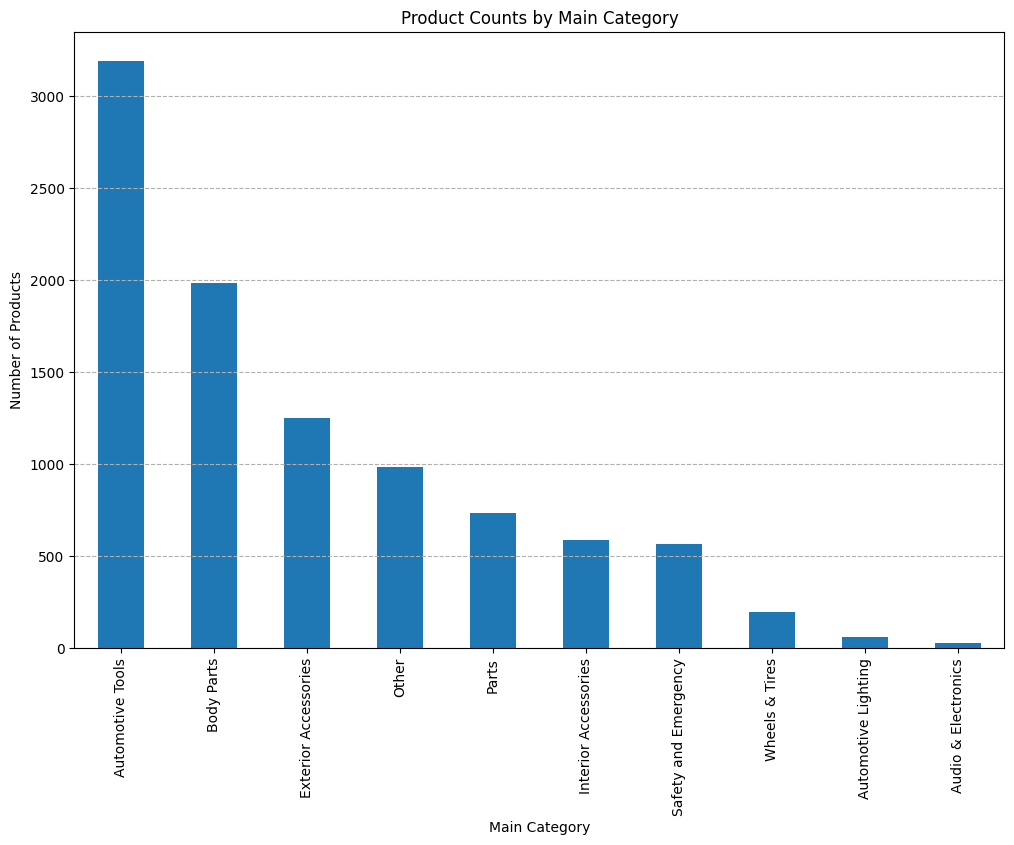

In [ ]:
category_counts = df['Main Category'].value_counts()

plt.figure(figsize=(12, 8))
category_counts.plot(kind='bar')
plt.title('Product Counts by Main Category')
plt.xlabel('Main Category')
plt.ylabel('Number of Products')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--')
plt.show()

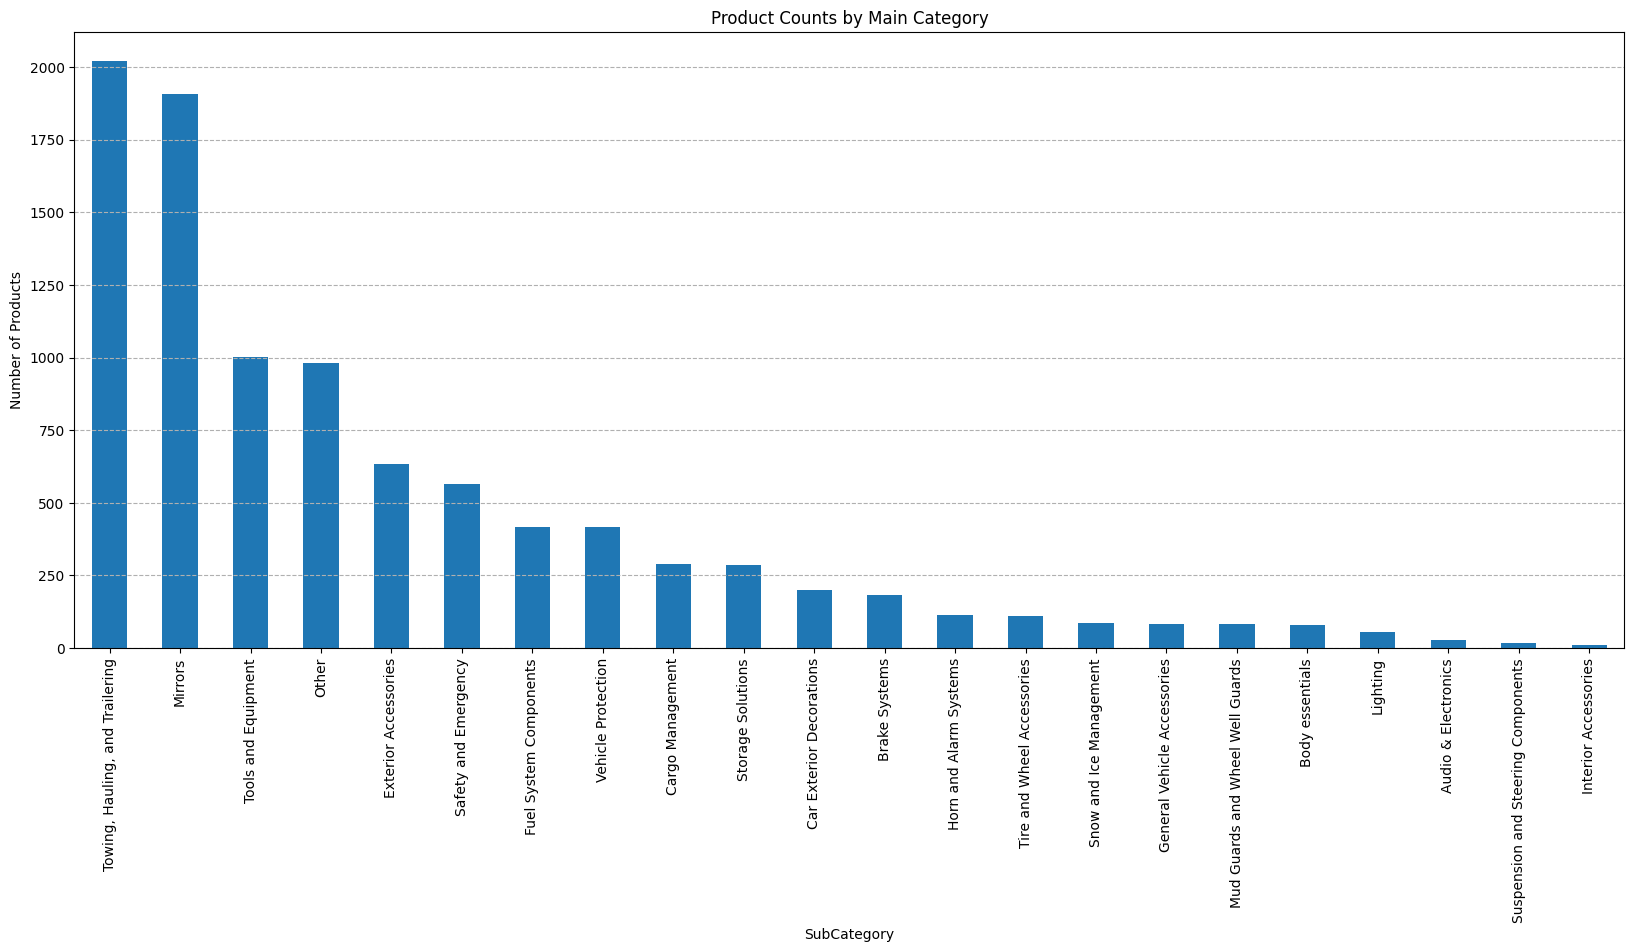

In [ ]:
# Calculate the count of items in each main category
subcategory_counts = df['SubCategory'].value_counts()

plt.figure(figsize=(20, 8))
subcategory_counts.plot(kind='bar')
plt.title('Product Counts by Main Category')
plt.xlabel('SubCategory')
plt.ylabel('Number of Products')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--')
plt.show()

Next step: I explore the stock column, and clean it, in such a way that it only shows the stock numbers.

In [ ]:
def extract_stock_number(stock_string):
    numbers = re.findall(r'\d+', stock_string)
    if numbers:
        return int(numbers[0])
    return None



In [ ]:
df['Stock update'] = df['Stock update'].apply(extract_stock_number)


In [ ]:
df.head(5)

,Title,Price,Number reviews,Real price,Free days,Shipment,Delivery Date,How many time in past month,Stock update,SubCategory,Main Category
0,Dorman 955-167 Driver Side Power Door Mirror f...,35,101,$1.92,90 days FREE. Terms apply.,Yes,"Mon, Jun 19",50+ bought in past week,7,Mirrors,Body Parts
1,CURT 51323 Quick Plug Electric Trailer Brake C...,19,386,$1.93,90 days FREE. Terms apply.,Yes,"Mon, Jun 19",50+ bought in past week,4,Brake Systems,Parts
2,HAMPTON PROD Keeper - 48” Carabiner Bungee Cor...,13,"1,573",$2.90,90 days FREE. Terms apply.,Yes,"Mon, Jun 19",50+ bought in past week,16,Cargo Management,Interior Accessories
3,"CR Brophy Machine Works RB34 1"" x 3/4"" Hitch B...",2,9,$2.90,90 days FREE. Terms apply.,Yes,"Mon, Jun 19",10% off coupon Details,3,"Towing, Hauling, and Trailering",Automotive Tools
4,"Ampper Blind Spot Mirror, 2"" Round HD Glass Fr...",8,"20,378",$3.14,90 days FREE. Terms apply.,Yes,"Mon, Jun 19",50+ bought in past week,2,Mirrors,Body Parts


Now it's time to clean the delivery date column due to inconsistency. First, we need to remove weekday names from the column and then separate the earliest and latest delivery dates for entries with two available dates. If there is only one date, it will be used as both the earliest and latest delivery dates.

Another issue is the unknown exact date when the sample was scraped from the Amazon website. Therefore, I will consider the day before the earliest date in the dataset as the data scraping date and calculate delivery days based on that.

In [ ]:
# Function to remove weekday names
def remove_weekday_names(row):
    parts = row.split(", ")
    if len(parts) > 1:
        return parts[1]
    else:
        return row


df['Delivery Date Cleaned'] = df['Delivery Date'].apply(remove_weekday_names)
df[['Title', 'Delivery Date', 'Delivery Date Cleaned']].head()

,Title,Delivery Date,Delivery Date Cleaned
0,Dorman 955-167 Driver Side Power Door Mirror f...,"Mon, Jun 19",Jun 19
1,CURT 51323 Quick Plug Electric Trailer Brake C...,"Mon, Jun 19",Jun 19
2,HAMPTON PROD Keeper - 48” Carabiner Bungee Cor...,"Mon, Jun 19",Jun 19
3,"CR Brophy Machine Works RB34 1"" x 3/4"" Hitch B...","Mon, Jun 19",Jun 19
4,"Ampper Blind Spot Mirror, 2"" Round HD Glass Fr...","Mon, Jun 19",Jun 19


Check for consistency in "Delivery Date Cleaned" column.

In [ ]:
df['Delivery Date Cleaned'].unique()

array(['Jun 19', 'Jun 20', 'Jun 26 - Jul 11', 'Jun 22', 'Jun 27 - Jul 13',
       'Jun 26 - Jul 12', 'Jun 26', 'Jun 15 - 23', 'Jun 23 - Jul 6',
       'Jun 23', 'Jun 23 - Jul 10', 'Jun 15 - 21', 'Jun 28 - Jul 14',
       'Jun 30 - Jul 24'], dtype=object)

A formatting inconsistency was found in the "Delivery Date" column, where delivery date ranges within the same month omit the month name for the latest delivery date (e.g., "Jun 15 - 23"), while ranges spanning two months include month names for both dates (e.g., "Jun 23 - Jul 6"). To ensure consistency and clarity, a corrective function was implemented to append the month name to the latest delivery date when it's missing. This solution standardizes date range representations, enhancing the dataset's accuracy for analysis.

In [ ]:
# Adjusted function to handle delivery date ranges and ensure month names are correctly applied

def adjust_delivery_dates(row):
    parts = row.split(" - ")
    if len(parts) == 2:
        start_part, end_part = parts
        # Check if the end part already contains a month name by looking for a space, indicating "Month Day"
        if " " not in end_part:
            # If not, prepend the month from the start part
            month = start_part.split(" ")[0]
            end_part = month + " " + end_part
    else:
        start_part = end_part = parts[0]

    # Append the year "2022" for consistent datetime formatting
    start_date_str = f"{start_part} 2022"
    end_date_str = f"{end_part} 2022"
    return start_date_str, end_date_str


In [ ]:
df['Earliest Delivery Date'], df['Latest Delivery Date'] = zip(*df['Delivery Date Cleaned'].apply(adjust_delivery_dates))

df['Earliest Delivery Date'] = pd.to_datetime(df['Earliest Delivery Date'], errors='coerce')
df['Latest Delivery Date'] = pd.to_datetime(df['Latest Delivery Date'], errors='coerce')

df[['Title', 'Delivery Date Cleaned', 'Earliest Delivery Date', 'Latest Delivery Date']].head()

,Title,Delivery Date Cleaned,Earliest Delivery Date,Latest Delivery Date
0,Dorman 955-167 Driver Side Power Door Mirror f...,Jun 19,2022-06-19,2022-06-19
1,CURT 51323 Quick Plug Electric Trailer Brake C...,Jun 19,2022-06-19,2022-06-19
2,HAMPTON PROD Keeper - 48” Carabiner Bungee Cor...,Jun 19,2022-06-19,2022-06-19
3,"CR Brophy Machine Works RB34 1"" x 3/4"" Hitch B...",Jun 19,2022-06-19,2022-06-19
4,"Ampper Blind Spot Mirror, 2"" Round HD Glass Fr...",Jun 19,2022-06-19,2022-06-19


Now I add two more columns, showing the number of days from order to the earliest and latest delivery dates.

To do this, I consider one day before the earliest date on the dataset as order date.

In [ ]:
# Calculate the "today" date
today_date = df['Earliest Delivery Date'].min() - timedelta(days=1)

# Calculate the number of days from "today" until the earliest and latest delivery dates
df['Days from Today to Earliest'] = (df['Earliest Delivery Date'] - today_date).dt.days
df['Days from Today to Latest'] = (df['Latest Delivery Date'] - today_date).dt.days
df[['Title', 'Earliest Delivery Date', 'Latest Delivery Date', 'Days from Today to Earliest', 'Days from Today to Latest']].head()


,Title,Earliest Delivery Date,Latest Delivery Date,Days from Today to Earliest,Days from Today to Latest
0,Dorman 955-167 Driver Side Power Door Mirror f...,2022-06-19,2022-06-19,5,5
1,CURT 51323 Quick Plug Electric Trailer Brake C...,2022-06-19,2022-06-19,5,5
2,HAMPTON PROD Keeper - 48” Carabiner Bungee Cor...,2022-06-19,2022-06-19,5,5
3,"CR Brophy Machine Works RB34 1"" x 3/4"" Hitch B...",2022-06-19,2022-06-19,5,5
4,"Ampper Blind Spot Mirror, 2"" Round HD Glass Fr...",2022-06-19,2022-06-19,5,5


Let's explore these two columns: "Free days" and "How many time in past month"

Inconsistency is noticibale on these two columns, therefore I explore their unique values.

In [ ]:
unique_values_free_days = df['Free days'].unique()
unique_values_times_in_past_month = df['How many time in past month'].unique()

print("free_days:" ,unique_values_free_days)
print("times_in_past_month:" ,unique_values_times_in_past_month)

free_days: ['90 days FREE. Terms apply.' '$12.00 off coupon Details'
 '$30.00 off coupon Details' '5% off coupon Details'
 '$15.00 off coupon Details' '15% off coupon Details'
 '10% off coupon Details' '$20.00 off coupon Details'
 '$10.00 off coupon Details' 'of select items' 'Save 10% when you buy'
 '$300.00' '$50.00' 'Save' 'when you buy' '$55.00'
 '$12.10 off coupon Details']
times_in_past_month: ['50+ bought in past week' '10% off coupon Details'
 '90 days FREE. Terms apply.' '5% off coupon Details']


Leveraging domain knowledge, we understand that Amazon indicates when a product is a frequently purchased item, signifying it has sold more than 50 times in the past month.

In [ ]:
# Create a binary value for purchase frequency
def purchase_frequency_binary(value):
    return 1 if '50+' in value else 0

df['Frequently Purchased'] = df['How many time in past month'].apply(purchase_frequency_binary)

Then we look at both columns to find coupons and offers.

In [ ]:
def extract_coupons_discounts(value):
    if pd.isna(value):
        return None
    money_discount_match = re.search(r'\$(\d+\.?\d*)', value)
    if money_discount_match:
        return '$' + money_discount_match.group(1)
    percent_discount_match = re.search(r'(\d+)%', value)
    if percent_discount_match:
        return percent_discount_match.group(1) + '%'
    return None

def extract_promotions(free_days, purchased_month):
    promotions = set()
    free_days_discount = extract_coupons_discounts(free_days)
    if free_days_discount:
        promotions.add(free_days_discount)

    purchased_month_discount = extract_coupons_discounts(purchased_month)
    if purchased_month_discount:
        promotions.add(purchased_month_discount)

    return ', '.join(promotions) if promotions else None

df['Promotions'] = df.apply(lambda x: extract_promotions(x['Free days'], x['How many time in past month']), axis=1)


In [ ]:
df["Promotions"].unique()

array([None, '10%', '$12.00', '$30.00', '5%', '$15.00', '15%',
       '10%, $20.00', '$10.00', '10%, 5%', '$300.00', '$50.00', '$20.00',
       '$55.00', '10%, $12.10'], dtype=object)

As we can see, the promotions can be categorized into four main types:

1- None: indicating no promotion.

2- Percentage Discounts: Promotions offering a reduction based on a percentage of the original price, such as "10%" or "15%."

3- Cash Discounts: Direct monetary reductions on purchases, indicated by specific amounts like "$12.00" or "$30.00."

4- Combined Promotions: Offers that include both a percentage discount and a cash discount in one promotion, like "10%, $12.10" or "$20.00, 10%."

These types reflect a mix of strategies to appeal to consumers through both flat-rate reductions and percentage-based savings, sometimes combining both to enhance the appeal.

In [ ]:
def warranty_or_return_policy(row):

    # Combine the text
    combined_text = str(row['Free days']) + ' ' + str(row['How many time in past month'])
    if '90 days' in combined_text:
        return '90 days Warranty'
    return '30 days Free Return'

df['Return and Warranty'] = df.apply(warranty_or_return_policy, axis=1)
df[['Free days', 'How many time in past month', 'Return and Warranty']].head()


,Free days,How many time in past month,Return and Warranty
0,90 days FREE. Terms apply.,50+ bought in past week,90 days Warranty
1,90 days FREE. Terms apply.,50+ bought in past week,90 days Warranty
2,90 days FREE. Terms apply.,50+ bought in past week,90 days Warranty
3,90 days FREE. Terms apply.,10% off coupon Details,90 days Warranty
4,90 days FREE. Terms apply.,50+ bought in past week,90 days Warranty


Now it's time to remove the columns we no longer need them.

In [ ]:
df.drop(['Free days', 'Shipment','Real price', 'Delivery Date', 'Delivery Date Cleaned', 'How many time in past month'], axis=1, inplace=True)
df.rename(columns={
    'Days from Today to Earliest': 'Days to Earliest Delivery',
    'Days from Today to Latest': 'Days to Latest Delivery'
}, inplace=True)
df.head(4)

,Title,Price,Number reviews,Stock update,SubCategory,Main Category,Earliest Delivery Date,Latest Delivery Date,Days to Earliest Delivery,Days to Latest Delivery,Frequently Purchased,Promotions,Return and Warranty
0,Dorman 955-167 Driver Side Power Door Mirror f...,35,101,7,Mirrors,Body Parts,2022-06-19,2022-06-19,5,5,1,None,90 days Warranty
1,CURT 51323 Quick Plug Electric Trailer Brake C...,19,386,4,Brake Systems,Parts,2022-06-19,2022-06-19,5,5,1,None,90 days Warranty
2,HAMPTON PROD Keeper - 48” Carabiner Bungee Cor...,13,"1,573",16,Cargo Management,Interior Accessories,2022-06-19,2022-06-19,5,5,1,None,90 days Warranty
3,"CR Brophy Machine Works RB34 1"" x 3/4"" Hitch B...",2,9,3,"Towing, Hauling, and Trailering",Automotive Tools,2022-06-19,2022-06-19,5,5,0,10%,90 days Warranty


In [ ]:
df.to_csv('/content/processed.csv', index=False)


The dataset is ready for feeding to BI tools such as Tableau and PowerBI to make dashboards.

However, for furthure analysis I plan to do with Python, I need the following data preprocessing.  

In [ ]:
df['Number reviews'] = df['Number reviews'].str.replace(',', '').astype(int)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

In [ ]:
promotions_categories = df['Promotions'].unique()
return_warranty_categories = df['Return and Warranty'].unique()

promotions_categories, return_warranty_categories


(array([None, '10%', '$12.00', '$30.00', '5%', '$15.00', '15%',
        '10%, $20.00', '$10.00', '10%, 5%', '$300.00', '$50.00', '$20.00',
        '$55.00', '10%, $12.10'], dtype=object),
 array(['90 days Warranty', '30 days Free Return'], dtype=object))

In [ ]:
# Creating a binary column for 'Promotions'
df['Has Promotion'] = df['Promotions'].apply(lambda x: 0 if x == None else 1)
# Creating a binary column for 'Warranty'
df['Warranty'] = df['Return and Warranty'].apply(lambda x: 0 if x == '30 days Free Return' else 1)
df[['Promotions', 'Has Promotion','Warranty', 'Return and Warranty']].head()

,Promotions,Has Promotion,Warranty,Return and Warranty
0,None,0,1,90 days Warranty
1,None,0,1,90 days Warranty
2,None,0,1,90 days Warranty
3,10%,1,1,90 days Warranty
4,None,0,1,90 days Warranty


In [ ]:
df['Promotions'] = df['Has Promotion']
df.drop(['Has Promotion', 'Return and Warranty'], axis=1, inplace=True)


In [ ]:
df.head()

,Title,Price,Number reviews,Stock update,SubCategory,Main Category,Earliest Delivery Date,Latest Delivery Date,Days to Earliest Delivery,Days to Latest Delivery,Frequently Purchased,Promotions,Warranty
0,Dorman 955-167 Driver Side Power Door Mirror f...,35.0,101,7,Mirrors,Body Parts,2022-06-19,2022-06-19,5,5,1,0,1
1,CURT 51323 Quick Plug Electric Trailer Brake C...,19.0,386,4,Brake Systems,Parts,2022-06-19,2022-06-19,5,5,1,0,1
2,HAMPTON PROD Keeper - 48” Carabiner Bungee Cor...,13.0,1573,16,Cargo Management,Interior Accessories,2022-06-19,2022-06-19,5,5,1,0,1
3,"CR Brophy Machine Works RB34 1"" x 3/4"" Hitch B...",2.0,9,3,"Towing, Hauling, and Trailering",Automotive Tools,2022-06-19,2022-06-19,5,5,0,1,1
4,"Ampper Blind Spot Mirror, 2"" Round HD Glass Fr...",8.0,20378,2,Mirrors,Body Parts,2022-06-19,2022-06-19,5,5,1,0,1


In [ ]:
df_new = df.drop(['Latest Delivery Date', 'Earliest Delivery Date'], axis=1)
df_new.head()

,Title,Price,Number reviews,Stock update,SubCategory,Main Category,Days to Earliest Delivery,Days to Latest Delivery,Frequently Purchased,Promotions,Warranty
0,Dorman 955-167 Driver Side Power Door Mirror f...,35.0,101,7,Mirrors,Body Parts,5,5,1,0,1
1,CURT 51323 Quick Plug Electric Trailer Brake C...,19.0,386,4,Brake Systems,Parts,5,5,1,0,1
2,HAMPTON PROD Keeper - 48” Carabiner Bungee Cor...,13.0,1573,16,Cargo Management,Interior Accessories,5,5,1,0,1
3,"CR Brophy Machine Works RB34 1"" x 3/4"" Hitch B...",2.0,9,3,"Towing, Hauling, and Trailering",Automotive Tools,5,5,0,1,1
4,"Ampper Blind Spot Mirror, 2"" Round HD Glass Fr...",8.0,20378,2,Mirrors,Body Parts,5,5,1,0,1


<ipython-input-33-fb2bf5c95b5e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_new.corr()


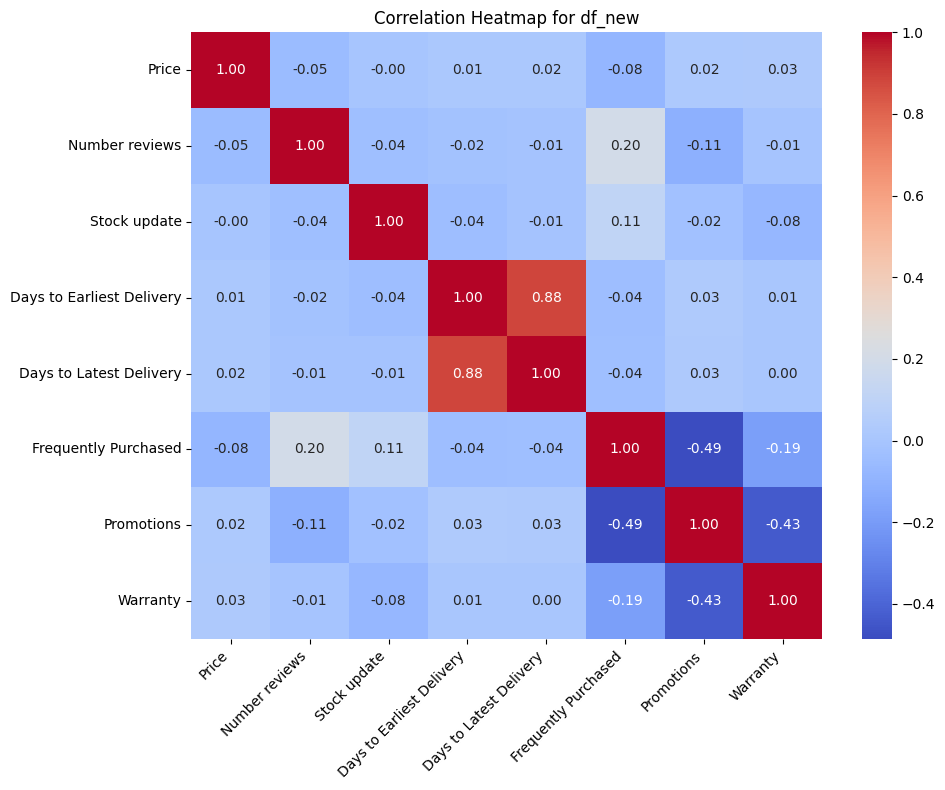

In [ ]:
correlation_matrix = df_new.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap for df_new')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The correlation matrix provides insights into how different numerical variables in the dataset are related to each other. Here's a short interpretation of some key observations:

**Price and Reviews:** The slight negative correlation (-0.054) suggests that as the price increases, the number of reviews slightly decreases, though the relationship is weak and might not be significant.

**Days to Earliest/Latest Delivery:** There's a very strong positive correlation (0.884) between the days to the earliest delivery and the days to the latest delivery, which is expected as these two metrics are closely related by nature.

**Frequently Purchased and Promotions:** There's a moderate negative correlation (-0.486) indicating that items frequently purchased tend to have fewer promotions applied to them. This could suggest that items that sell well don't need as many incentives to attract buyers.

**Promotions and Warranty: **The negative correlation (-0.434) suggests that products with promotions are less likely to have longer warranty periods, indicating that promotional items might be different in nature (e.g., clearance items or special sales) from those with extended warranties.

**Frequently Purchased and Number of Reviews:** There's a positive correlation (0.198) suggesting that items that are frequently purchased tend to have more reviews. This is intuitive as more purchases would likely lead to more customer feedback. However, the correlation is weak, this might be due to reason we consider any product with 50+ purchases during last month as a frequently purchased item, while we don't know the exact number of purchases.

Overall, the correlations between these variables indicate some expected relationships based on business logic, such as the link between delivery times and the relationship between promotions and frequently purchased items. However, many correlations are weak, indicating that there's no strong linear relationship between most pairs of variables in the dataset. This highlights the complexity of consumer behavior and the factors influencing purchase decisions.

To investigate the effect of different variables on making an item a frequently purchased product, let's conduct a **Logistic Regression Analysis**.

In [ ]:
missing_values = df_new.isnull().sum()
missing_values

Title                         0
Price                        12
Number reviews                0
Stock update                  0
SubCategory                   0
Main Category                 0
Days to Earliest Delivery     0
Days to Latest Delivery       0
Frequently Purchased          0
Promotions                    0
Warranty                      0
dtype: int64

We only have 12 missing values in price. There are two main approaches to handle missing values. We can simply remove those ovservations since it does not contain a huge part of the data, or impute them using mean/median, or more complex approaches such as KNN.

For this analysis, I decide to fill missing values with their respective **median of their subcategory**.

In [ ]:
medians = df.groupby('SubCategory')['Price'].transform('median')

df_new['Price'] = df_new['Price'].fillna(medians)

missing_values_after_imputation = df_new.isnull().sum()
missing_values_after_imputation

Title                        0
Price                        0
Number reviews               0
Stock update                 0
SubCategory                  0
Main Category                0
Days to Earliest Delivery    0
Days to Latest Delivery      0
Frequently Purchased         0
Promotions                   0
Warranty                     0
dtype: int64

**Outlier Investigation**

In [ ]:
Q1 = df[['Price', 'Number reviews', 'Stock update']].quantile(0.25)
Q3 = df[['Price', 'Number reviews', 'Stock update']].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df_new[~((df_new[['Price', 'Number reviews', 'Stock update']] < lower_bound) | (df_new[['Price', 'Number reviews', 'Stock update']] > upper_bound)).any(axis=1)]

# Comparing the shape of the original and filtered DataFrames to see how many rows were removed
original_shape = df_new.shape
filtered_shape = df_filtered.shape

original_shape, filtered_shape


((9573, 11), (7661, 11))

In [ ]:
# Calculating the number of outliers in each column

outliers_price = ((df_new['Price'] < lower_bound['Price']) | (df_new['Price'] > upper_bound['Price']))
outliers_reviews = ((df_new['Number reviews'] < lower_bound['Number reviews']) | (df_new['Number reviews'] > upper_bound['Number reviews']))
outliers_stock_update = ((df_new['Stock update'] < lower_bound['Stock update']) | (df_new['Stock update'] > upper_bound['Stock update']))

num_outliers_price = outliers_price.sum()
num_outliers_reviews = outliers_reviews.sum()
num_outliers_stock_update = outliers_stock_update.sum()
num_outliers_price, num_outliers_reviews, num_outliers_stock_update

(786, 1198, 0)

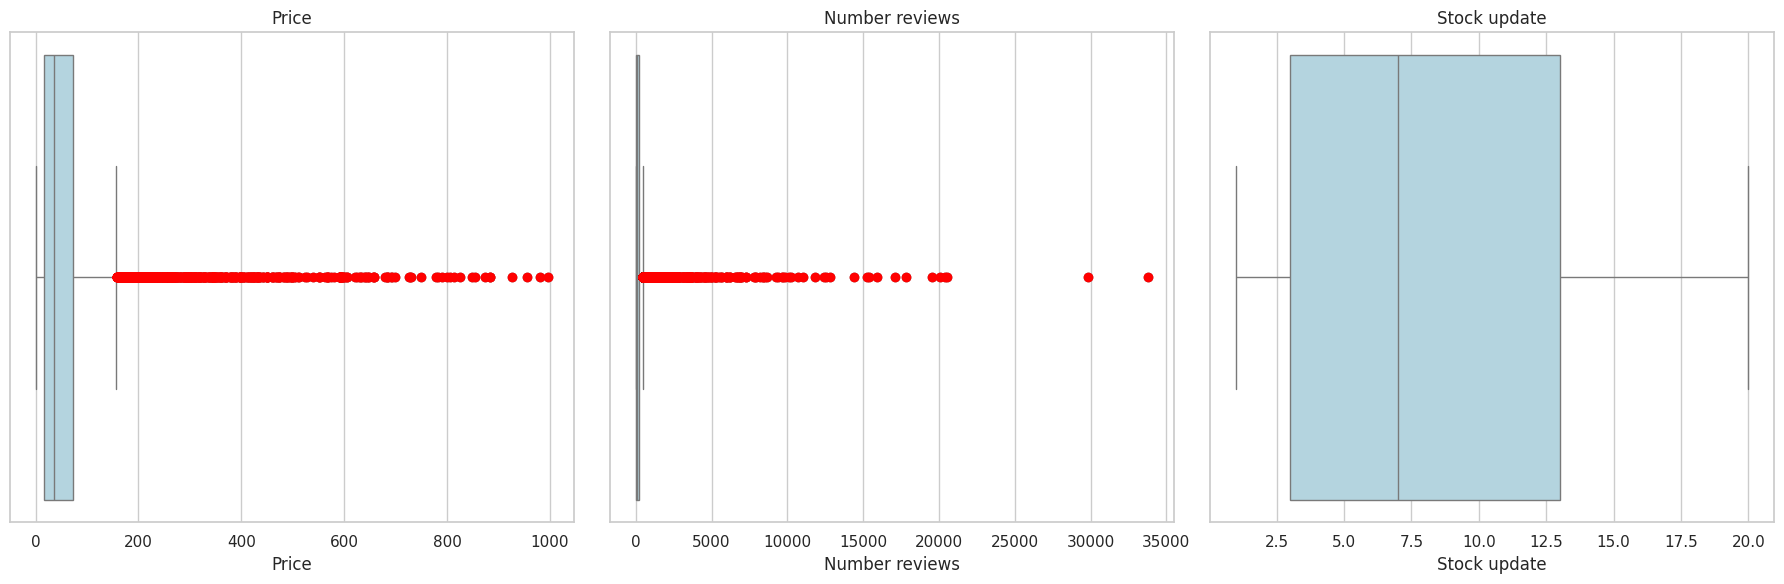

In [ ]:
sns.set(style="whitegrid")

# Creating box plots for each column with outliers shown in red
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(x=df_new['Price'], color="lightblue", ax=axes[0], showfliers=True)
axes[0].scatter(df_new.loc[outliers_price, 'Price'], [0] * num_outliers_price, color='red', zorder=5)
axes[0].set_title('Price')
sns.boxplot(x=df_new['Number reviews'], color="lightblue", ax=axes[1], showfliers=True)
axes[1].scatter(df_new.loc[outliers_reviews, 'Number reviews'], [0] * num_outliers_reviews, color='red', zorder=5)
axes[1].set_title('Number reviews')
sns.boxplot(x=df_new['Stock update'], color="lightblue", ax=axes[2], showfliers=True)
axes[2].scatter(df_new.loc[outliers_stock_update, 'Stock update'], [0] * num_outliers_stock_update, color='red', zorder=5)
axes[2].set_title('Stock update')

plt.tight_layout()
plt.show()


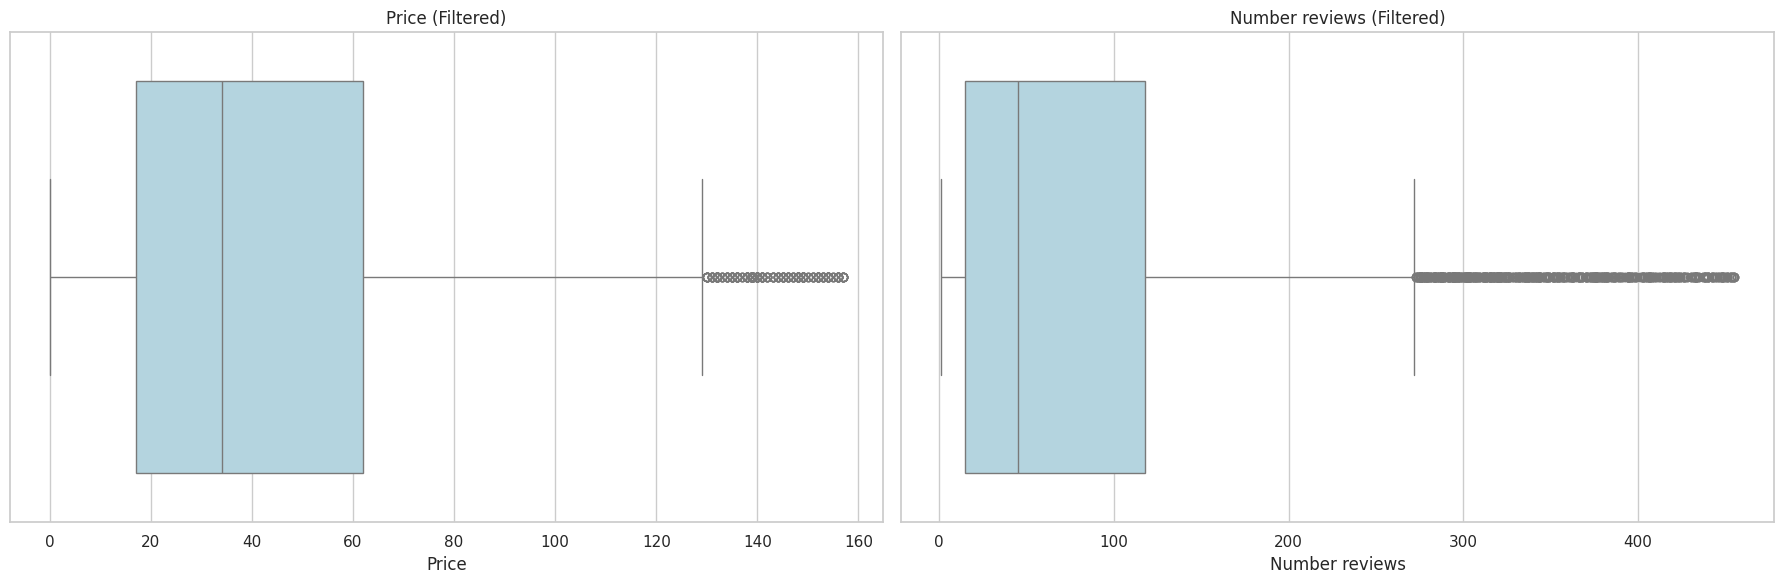

In [ ]:
# Creating box plots for the filtered DataFrame 'df_filtered' to see the distribution after removing outliers
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Price
sns.boxplot(x=df_filtered['Price'], color="lightblue", ax=axes[0], showfliers=True)
axes[0].set_title('Price (Filtered)')

# Number reviews
sns.boxplot(x=df_filtered['Number reviews'], color="lightblue", ax=axes[1], showfliers=True)
axes[1].set_title('Number reviews (Filtered)')


plt.tight_layout()
plt.show()


**Normalizing the features**

In [ ]:

# Preparing the DataFrame for logistic regression analysis
df_lr = df_filtered[['Price', 'Number reviews', 'Stock update', 'Promotions', 'Frequently Purchased']]
X = df_lr.drop('Frequently Purchased', axis=1)
y = df_lr['Frequently Purchased']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

classification_report_result = classification_report(y_test, y_pred)
confusion_matrix_result = confusion_matrix(y_test, y_pred)

In [ ]:

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# For statistical significance (p-values) of each variable:
X_const = sm.add_constant(X_scaled)
logit_model = sm.Logit(y, X_const)
result = logit_model.fit()
print("\nModel Summary:")
print(result.summary())

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.71      0.75      1193
           1       0.72      0.81      0.76      1106

    accuracy                           0.76      2299
   macro avg       0.76      0.76      0.76      2299
weighted avg       0.76      0.76      0.76      2299

Confusion Matrix:
[[846 347]
 [212 894]]
Optimization terminated successfully.
         Current function value: 0.483135
         Iterations 6

Model Summary:
                            Logit Regression Results                            
Dep. Variable:     Frequently Purchased   No. Observations:                 7661
Model:                            Logit   Df Residuals:                     7656
Method:                             MLE   Df Model:                            4
Date:                  Sat, 30 Mar 2024   Pseudo R-squ.:                  0.3022
Time:                          09:55:49   Log-Likelihood:                -3701.3
conve


**Model Fit and Statistical Significance:**

**Pseudo R-squared** (R²): 0.3022, shows the model's explanatory power. It indicates that approximately 30% of the variability in the dependent variable (being frequently purchased) is explained by the model.

**LLR p-value**: Is less than 0.000, showing that the model as a whole significantly differs from a null model with no predictors.

**Coefficients and Their Interpretations:**

Constant (const): The constant term's coefficient is -0.0633, suggesting the log odds of an item being frequently purchased when all predictors are zero. Its p-value of 0.031 indicates statistical significance.

Variable x1 (**Price**): The coefficient of -0.1627 implies that as the price increases, the log odds of being frequently purchased decrease, holding other variables constant. Its significant p-value (0.000) indicates a strong negative impact of price on purchase frequency.

Variable x2 (**Number of Reviews**): With a coefficient of 1.0242, this indicates that an increase in the number of reviews is associated with an increase in the log odds of being frequently purchased, a positive and statistically significant relationship.

Variable x3 (**Stock Update**): The coefficient of 0.2573 suggests a positive relationship between stock updates and the likelihood of being frequently purchased. Its significance is confirmed by a p-value of 0.000.

Variable x4 (**Promotions**): The coefficient of -1.1318 indicates a negative relationship between having promotions and the likelihood of being frequently purchased. This variable's strong influence is also statistically significant, with a p-value of 0.000.

Conclusion:
The model indicates that the number of reviews and stock updates positively influence an item's likelihood of being frequently purchased, while price and promotions have a negative impact. The significant p-values for all predictors confirm these relationships are statistically significant, suggesting they are not due to random chance. This analysis can help in understanding consumer behavior and inform strategies to increase purchase frequencies.

Logistic Regression Model for Prediction with adding Main category to predictions. To do this, we first encode the categorical varibale. Since the nature of Main category is nominal, we prefer one-hot encoding.

In [ ]:
df_one_hot = pd.get_dummies(df_filtered, columns=['Main Category'], drop_first=True)

In [ ]:
# Excluding 'SubCategory'
X = df_one_hot.drop(['Frequently Purchased', 'SubCategory'], axis=1)
y = df_one_hot['Frequently Purchased']

selected_features = ['Price', 'Number reviews', 'Stock update', 'Promotions']
selected_features.extend([col for col in df_one_hot.columns if 'Main Category_' in col])

X = X[selected_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# For statistical significance (p-values) of each variable:
X_const = sm.add_constant(X_scaled)
logit_model = sm.Logit(y, X_const)
result = logit_model.fit()
print("\nModel Summary:")
print(result.summary())


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76      1193
           1       0.73      0.79      0.76      1106

    accuracy                           0.76      2299
   macro avg       0.76      0.76      0.76      2299
weighted avg       0.76      0.76      0.76      2299

Confusion Matrix:
[[875 318]
 [236 870]]
Optimization terminated successfully.
         Current function value: 0.474447
         Iterations 6

Model Summary:
                            Logit Regression Results                            
Dep. Variable:     Frequently Purchased   No. Observations:                 7661
Model:                            Logit   Df Residuals:                     7647
Method:                             MLE   Df Model:                           13
Date:                  Sat, 30 Mar 2024   Pseudo R-squ.:                  0.3147
Time:                          09:55:49   Log-Likelihood:                -3634.7
conve

**Model Performance:**
The accuracy of the model is **76%**, which remains consistent with the previous model without Main Category variables. This suggests that adding Main Category as predictors didn't significantly change the overall accuracy.

Precision and recall are balanced across both classes (0 and 1), with F1-scores of 0.76 for both, indicating a balanced performance in predicting frequently and not frequently purchased items.

**Statistical Significance and Model Fit:**

Pseudo R-squared increased to 0.3147 from 0.3022, indicating a slight improvement in the model's explanatory power with the inclusion of Main Category variables. However, it always increases by adding more variables, therefor we can't conclude that this model is better than the previouse model which had fewer number of variables, by comparing R-squared.

Log-Likelihood improved to -3634.7 from -3701.3, suggesting the model fits the data slightly better than the previous model without Main Category variables.

LLR p-value remains at 0.000, indicating that the model is statistically significant.

**Coefficients and P-Values:**

The coefficients for previously included variables (Price, Number of Reviews, Stock Update, Promotions) remain statistically significant with similar effects on the likelihood of being frequently purchased.
Most Main Category variables (encoded as x5 to x13) have p-values greater than 0.05, suggesting that **they do not significantly contribute to predicting** whether an item is frequently purchased. This is indicated by the high p-values (e.g., 0.609, 0.466, 0.431), showing that the additional variables from Main Category encoding do not have statistically significant effects in differentiating frequently purchased items from those that are not.

**Conclusion:**
While the inclusion of Main Category variables slightly improved the model's fit, the high p-values associated with these variables suggest that most Main Category distinctions do not significantly contribute to the prediction of whether an item is frequently purchased.

This implies that **the Main Category variables individually did not provide significant predictive power** beyond what was achieved with the original set of predictors (Price, Number of Reviews, Stock Update, Promotions).

In [ ]:
df_one_hot.to_csv('/content/one-hot.csv', index=False)


In [ ]:
df_one_hot.drop('SubCategory', axis=1, inplace=True)

**Clustering**

For clustering I only keep days to earliest delivery column as it is highly correlated with the days to latest delivery column. Plus, since encoding the subcategory with one-hot method adds huge dimention to the data, I exclude it.

Then I perform **Clustering Analysis with K-means**.

And **visualize** the Clustering using **PCA for dimensionality reduction**.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for k=3: 0.2884364810771906


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for k=4: 0.3281001591575729


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for k=5: 0.3665299220358104


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for k=6: 0.3239692805093073


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for k=7: 0.2904973338517921


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for k=8: 0.29731172217404744


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for k=9: 0.2908372472096337


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for k=10: 0.2982021086073263


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for k=11: 0.3016879517934578


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for k=12: 0.300897777885889


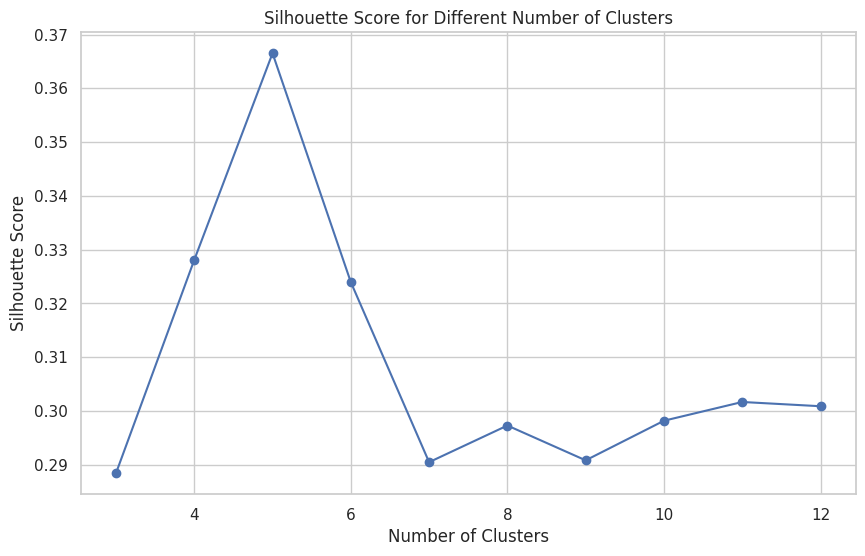

In [ ]:
features = ['Price', 'Number reviews', 'Stock update', 'Days to Earliest Delivery']
X = df_filtered[features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Price', 'Number reviews', 'Stock update', 'Days to Earliest Delivery'])
    ])

X_processed = preprocessor.fit_transform(X)

silhouette_scores = []
best_score = -1
best_k = 0
best_labels = None

for k in range(3, 13):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_processed)
    score = silhouette_score(X_processed, kmeans.labels_)
    silhouette_scores.append(score)
    print(f'Silhouette Score for k={k}: {score}')

    if score > best_score:
        best_score = score
        best_k = k
        best_labels = kmeans.labels_

plt.figure(figsize=(10, 6))
plt.plot(range(3, 13), silhouette_scores, marker='o')
plt.title('Silhouette Score for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()



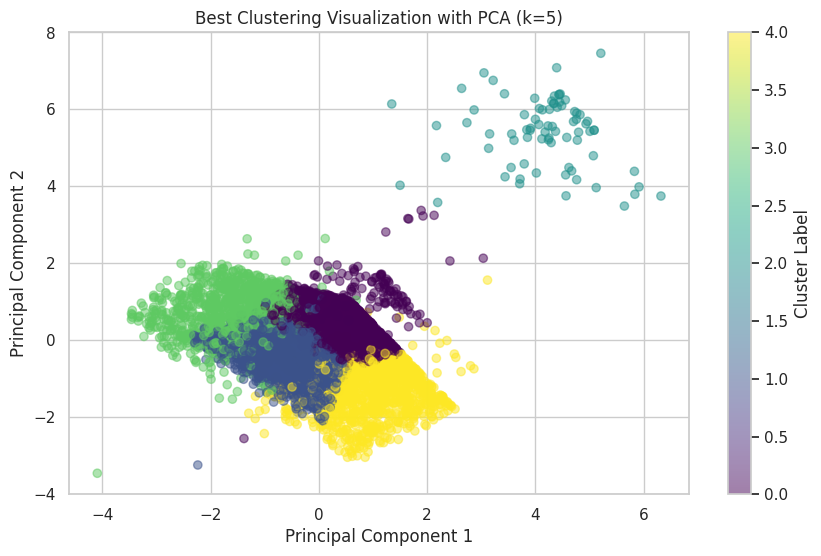

In [ ]:
# Visualizing the Clustering with the best k using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='viridis', marker='o', alpha=0.5)
plt.title(f'Best Clustering Visualization with PCA (k={best_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=3: Calinski-Harabasz Score = 2791.226558697488, Davies-Bouldin Score = 1.1147552947672368


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=4: Calinski-Harabasz Score = 3451.5431790129783, Davies-Bouldin Score = 0.9446977764873417


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=5: Calinski-Harabasz Score = 4486.405253021266, Davies-Bouldin Score = 0.7822506712709718


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=6: Calinski-Harabasz Score = 4147.783799265128, Davies-Bouldin Score = 0.9161866755495177


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=7: Calinski-Harabasz Score = 3957.8561595390815, Davies-Bouldin Score = 1.0094404470746818


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=8: Calinski-Harabasz Score = 3916.9110802411656, Davies-Bouldin Score = 1.069763933744761


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=9: Calinski-Harabasz Score = 3835.772544248314, Davies-Bouldin Score = 1.0358731174190348


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=10: Calinski-Harabasz Score = 3778.7784165632297, Davies-Bouldin Score = 0.9785552190271984


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=11: Calinski-Harabasz Score = 3750.968404314245, Davies-Bouldin Score = 0.9271431112125136


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=12: Calinski-Harabasz Score = 3679.36503358544, Davies-Bouldin Score = 0.9246652374334549


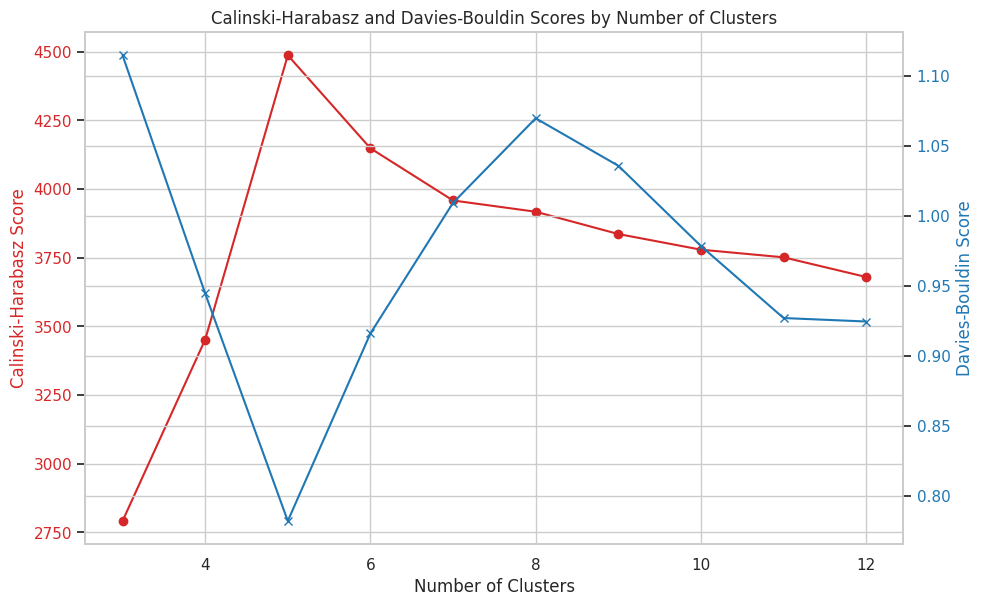

In [ ]:

calinski_harabasz_scores = []
davies_bouldin_scores = []

for k in range(3, 13):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_processed)
    labels = kmeans.labels_

    ch_score = calinski_harabasz_score(X_processed, labels)
    db_score = davies_bouldin_score(X_processed, labels)

    calinski_harabasz_scores.append(ch_score)
    davies_bouldin_scores.append(db_score)

    print(f'k={k}: Calinski-Harabasz Score = {ch_score}, Davies-Bouldin Score = {db_score}')

# Plotting the scores
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Calinski-Harabasz Score', color=color)
ax1.plot(range(3, 13), calinski_harabasz_scores, color=color, marker='o', label='Calinski-Harabasz Score')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Davies-Bouldin Score', color=color)  # we already handled the x-label with ax1
ax2.plot(range(3, 13), davies_bouldin_scores, color=color, marker='x', label='Davies-Bouldin Score')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Calinski-Harabasz and Davies-Bouldin Scores by Number of Clusters')
plt.show()


In [ ]:
db_score = davies_bouldin_score(X_processed, best_labels)
print(f"Davies-Bouldin Index: {db_score}")


Davies-Bouldin Index: 0.7822506712709718


In [ ]:
ch_score = calinski_harabasz_score(X_processed, best_labels)
print(f"Calinski-Harabasz Index: {ch_score}")


Calinski-Harabasz Index: 4486.405253021266


In [ ]:
df_filtered['Kmeans Label'] = best_labels

# Analyze Each Cluster
cluster_means = df_filtered.groupby('Kmeans Label').mean()
print(cluster_means)
# To see the distribution of 'Main Category' within each cluster
for i in range(best_k):
    print(f"\nCluster {i} Main Category Distribution:")
    print(df_filtered[df_filtered['Kmeans Label'] == i]['Main Category'].value_counts())

                   Price  Number reviews  Stock update  \
Kmeans Label                                             
0              30.357857       47.506292      3.998709   
1              31.837274       58.086694     14.691701   
2              48.756410       61.166667      6.358974   
3              34.335249      295.824713      8.238506   
4             107.402962       59.257210      7.744349   

              Days to Earliest Delivery  Days to Latest Delivery  \
Kmeans Label                                                       
0                              5.038722                 5.040658   
1                              5.010199                 5.012981   
2                             12.000000                19.910256   
3                              5.016284                 5.023946   
4                              5.020265                 5.020265   

              Frequently Purchased  Promotions  Warranty  
Kmeans Label                                             

<ipython-input-57-76d4a8d740df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Kmeans Label'] = best_labels
<ipython-input-57-76d4a8d740df>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_means = df_filtered.groupby('Kmeans Label').mean()


---
"Cluster Analysis Interpretation"
---

### Cluster Analysis Interpretation

Based on the cluster characteristics and main category distributions provided, we can name and interpret each cluster as follows:

#### Cluster 0: "Basic Needs, Low Engagement"

**Characteristics:** Moderate price range with the lowest number of reviews, suggesting less engagement or newer products. Stock updates and delivery times are average, indicating standard supply chain efficiency. Moderately high warranty indicates reliability is valued. The promotion and frequently purchased rates are moderate.

**Main Categories:** Dominated by Automotive Tools, Body Parts, and Exterior Accessories. This cluster seems to cater to essential automotive needs, with a focus on basic maintenance and repairs.

#### Cluster 1: "Active Shoppers’ Choice"
**Characteristics:** Similar price range to Cluster 0 but with higher review numbers and stock updates, pointing to more popular or frequently purchased items. Slightly quicker delivery times and lower warranty, with a balance between promotions and frequently purchased items.

**Main Categories:** Similar to Cluster 0 but slightly less diversified. The emphasis remains on tools, parts, and accessories, possibly for a more engaged consumer base that values updates and variety.

### Cluster 2: "Long-Term Planners"

**Characteristics:** Highest prices with high review numbers but less frequent stock updates. Significantly longer delivery times, which might indicate special-order items or higher demand products. High warranty and moderate promotion rate suggest a focus on quality and investment in long-term use.

**Main Categories:** More evenly distributed across categories, though the sample size is much smaller. This cluster might represent specialized tools or parts that require more planning to purchase, such as upgrades or niche accessories.

### Cluster 3: "High Engagement, Everyday Users"

**Characteristics:** Slightly above average price, but significantly higher review numbers indicate high consumer engagement and satisfaction. Average stock updates and quick delivery times suggest efficient logistics. The highest rate of items being frequently purchased but lower promotions and warranties hint at loyal customers and less need for incentives.

**Main Categories:** Automotive Tools and Exterior Accessories lead, showing a focus on frequent maintenance or customization needs for everyday users.

### Cluster 4: "Premium Selection"

**Characteristics:** Significantly higher prices with above-average reviews, indicating a premium segment. Stock updates and delivery times are standard, with a high warranty level, underscoring a focus on quality and customer assurance. Moderate promotion and frequently purchased rates suggest a balance between exclusivity and popularity.

**Main Categories:** A good mix of tools, accessories, and body parts, pointing to a premium selection for enthusiasts or those seeking high-quality replacements.